In [357]:
import os
import shutil
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

# Aim
To predict whether a person has heart disease. This is done using decision tree algorithm and its derived random forest algorithm and the accuracy of both of them are compared.

The dataset taken is the **UCI heart disease dataset for cleveland** taken from kaggle.

# download dataset

In [340]:
py_dir = os.getcwd()

In [341]:
if os.getcwd() != "C:\\Users\\AJIN RUFUS\\.kaggle":
    os.chdir("C:\\Users\\AJIN RUFUS\\.kaggle")

In [346]:
dt_name = "heart-disease-cleveland"

# !kaggle datasets list -s "heart disease cleveland"

!kaggle datasets download -d "ritwikb3/heart-disease-cleveland"

Dataset URL: https://www.kaggle.com/datasets/ritwikb3/heart-disease-cleveland
License(s): CC-BY-SA-4.0




  0%|          | 0.00/3.49k [00:00<?, ?B/s]
100%|##########| 3.49k/3.49k [00:00<00:00, 7.04MB/s]


In [347]:
shutil.move(os.getcwd() + f"\\{dt_name}.zip", py_dir)

'C:\\Users\\AJIN RUFUS\\Downloads\\pandas\\statistics\\heart-disease-data\\heart-disease-cleveland.zip'

In [349]:
os.chdir(py_dir + f"\\{dt_name}")

# Loading Data

In [351]:
df = pd.read_csv("Heart_disease_cleveland_new.csv")
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,0,145,233,1,2,150,0,2.3,2,0,2,0
1,67,1,3,160,286,0,2,108,1,1.5,1,3,1,1
2,67,1,3,120,229,0,2,129,1,2.6,1,2,3,1
3,37,1,2,130,250,0,0,187,0,3.5,2,0,1,0
4,41,0,1,130,204,0,2,172,0,1.4,0,0,1,0


* cp - chest pain
* restbp - resting blood pressure (in mm Hg)
* chol - serum cholestol (in mg/dl)
* fbs - fasting blood pressure
* restecg - resting ecg
* thalach - maximum heart angina
* oldpeak - ST depresssion induced by exercise relative to est
* slope - slope of the peak exercide ST segment
* ca - number of major vessels (0-3) colored by flutoscopy
* thal - thalium heart scan
* hd - diagnosis of heart disease, predicted attribute

In [31]:
# # change column names - got from uci dataset website 
# df.columns = ["age", "sex", "cp",
#               "restbp", "chol", "fbs",
#               "restecg", "thalach", "exang",
#               "oldpeak", "slope", "ca",
#               "thal", "hd"]

# handle missing data

In [353]:
# identifying
df.dtypes

age           int64
sex           int64
cp            int64
trestbps      int64
chol          int64
fbs           int64
restecg       int64
thalach       int64
exang         int64
oldpeak     float64
slope         int64
ca            int64
thal          int64
target        int64
dtype: object

In [35]:
# since object is the data type for ca and thal
df["ca"].unique()

array(['0.0', '3.0', '2.0', '1.0', '?'], dtype=object)

In [36]:
df["thal"].unique()

array(['6.0', '3.0', '7.0', '?'], dtype=object)

In [37]:
df.loc[(df["ca"] == "?") | (df["thal"] == "?")]

,age,sex,cp,restbp,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,hd
87,53.0,0.0,3.0,128.0,216.0,0.0,2.0,115.0,0.0,0.0,1.0,0.0,?,0
166,52.0,1.0,3.0,138.0,223.0,0.0,0.0,169.0,0.0,0.0,1.0,?,3.0,0
192,43.0,1.0,4.0,132.0,247.0,1.0,2.0,143.0,1.0,0.1,2.0,?,7.0,1
266,52.0,1.0,4.0,128.0,204.0,1.0,0.0,156.0,1.0,1.0,2.0,0.0,?,2
287,58.0,1.0,2.0,125.0,220.0,0.0,0.0,144.0,0.0,0.4,2.0,?,7.0,0
302,38.0,1.0,3.0,138.0,175.0,0.0,0.0,173.0,0.0,0.0,1.0,?,3.0,0


In [38]:
# since only few lines are missing, we can remove them
df_cleaned = df.loc[(df["ca"] != "?") & (df["thal"] != "?")]

# Separate attribute and output

In [42]:
df_cleaned = df_cleaned.rename(columns={'target': 'hd'}) # to be more understandable

x = df_cleaned.drop("hd", axis = 1) # attrbutes

In [46]:
y = df_cleaned[["hd"]]             # output required to be predicted

# one hot encoding

* sex - male and female category.
* cp  - chest pain of four categories. (typical, atypical, non-anginal, asymptomatic)
* fbs - fasting bp category of <120 and >=120
* restecg - resting ecg of 3 categories
* exang - excercise induced angina of two yes and no
* slope - 3 categories of upsoling, flat and downsloping
* thal - thalium heart scan category of 3, normal, fixed defect and reversible defect

Since cp, restecg, slope and thal are categories, one hot encoding is required.\
since sex, fbs, exang are already binary, no encoding is required.

In [236]:
x_enc = pd.get_dummies(x, columns=["cp", "restecg", "slope", "thal"])
x_enc.head()

,age,sex,restbp,chol,fbs,thalach,exang,oldpeak,ca,cp_1.0,...,cp_4.0,restecg_0.0,restecg_1.0,restecg_2.0,slope_1.0,slope_2.0,slope_3.0,thal_3.0,thal_6.0,thal_7.0
0,63.0,1.0,145.0,233.0,1.0,150.0,0.0,2.3,0.0,True,...,False,False,False,True,False,False,True,False,True,False
1,67.0,1.0,160.0,286.0,0.0,108.0,1.0,1.5,3.0,False,...,True,False,False,True,False,True,False,True,False,False
2,67.0,1.0,120.0,229.0,0.0,129.0,1.0,2.6,2.0,False,...,True,False,False,True,False,True,False,False,False,True
3,37.0,1.0,130.0,250.0,0.0,187.0,0.0,3.5,0.0,False,...,False,True,False,False,False,False,True,True,False,False
4,41.0,0.0,130.0,204.0,0.0,172.0,0.0,1.4,0.0,False,...,False,False,False,True,True,False,False,True,False,False


In [239]:
x_enc = x_enc.drop("slope_3.0", axis=1)

x_enc = x_enc.drop("thal_7.0", axis=1)

In [358]:
# y["hd"].unique()

# we need to check if the person has heart disease or not
y.loc[y['hd'] > 0, 'hd'] = 1

# decison classification tree

In [246]:
# splitting data into test train data. test = 0.25 is default
x_train, x_test, y_train, y_test = train_test_split(x_enc, y, random_state=42)

In [247]:
dtc = DecisionTreeClassifier(random_state=42) # decision tree classifer

dtc = dtc.fit(x_train, y_train)               # model fitting

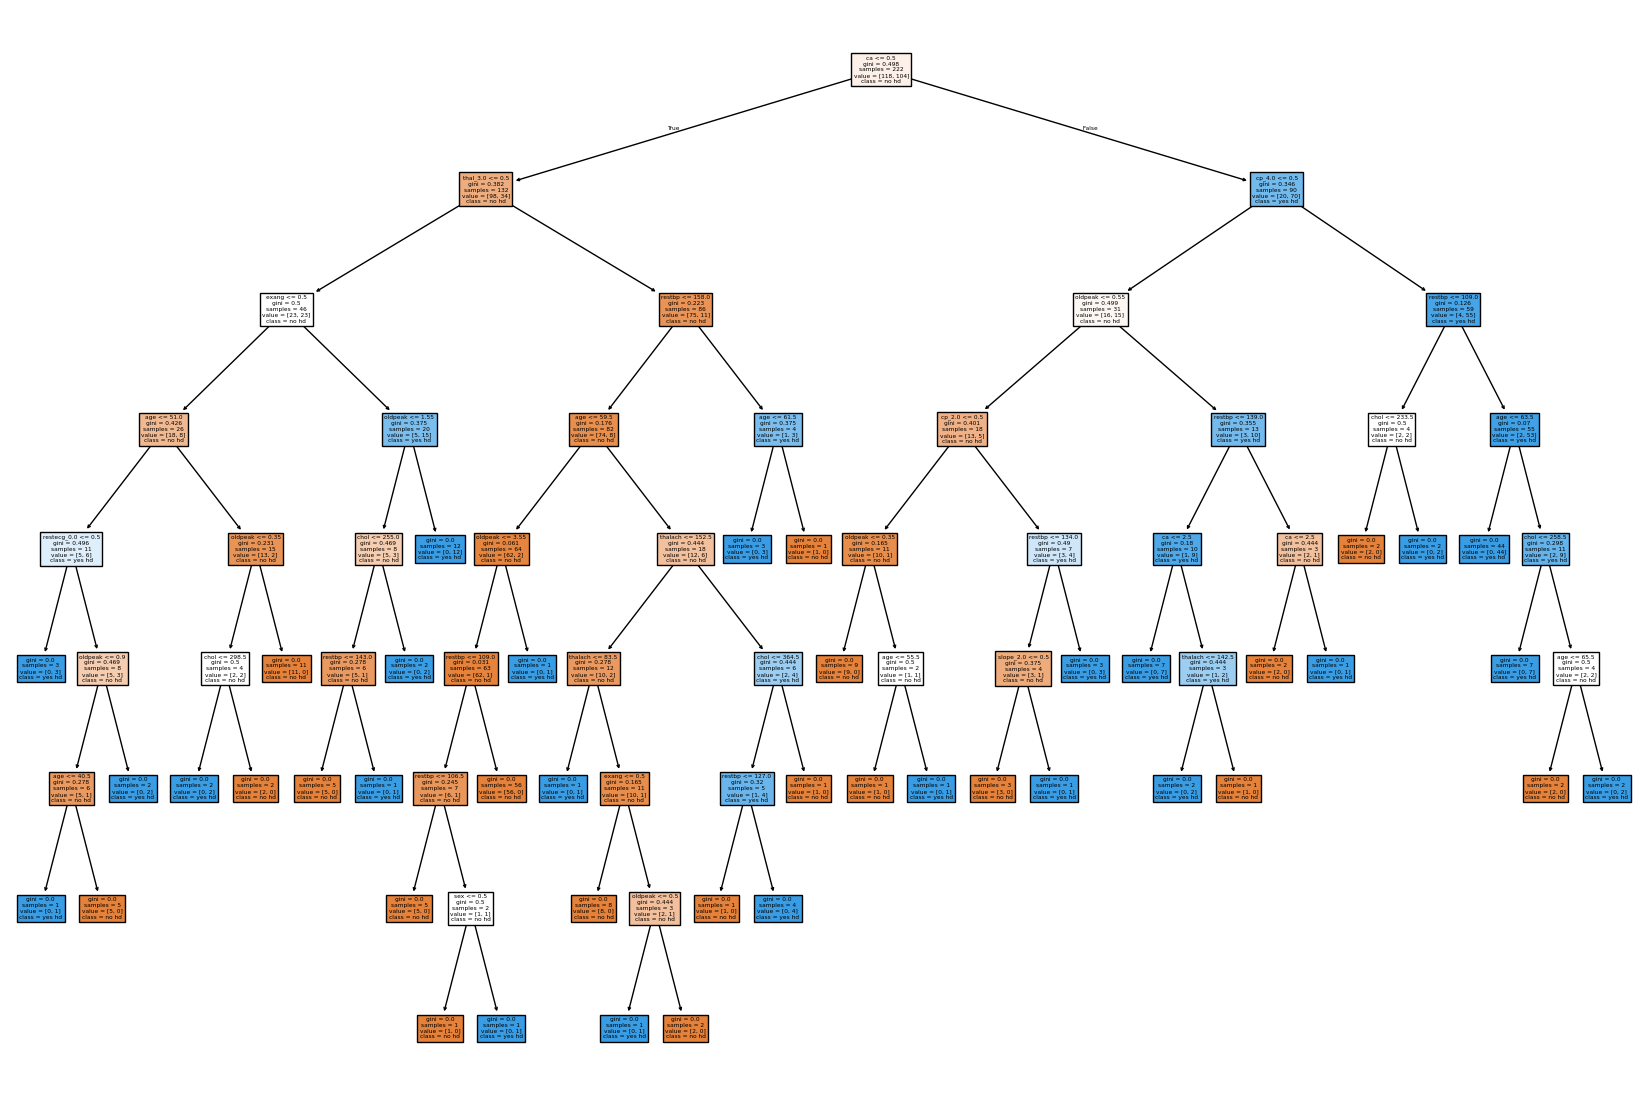

In [248]:
plt.figure(figsize=(21,14))
plot_tree(dtc, 
         filled = True,
         class_names=["no hd", "yes hd"],
         feature_names=x_enc.columns)
plt.show()

The computed decision tree has many number of trees, this can be bad as it may lead to overfitting

In [249]:
y_pred = dtc.predict(x_test)

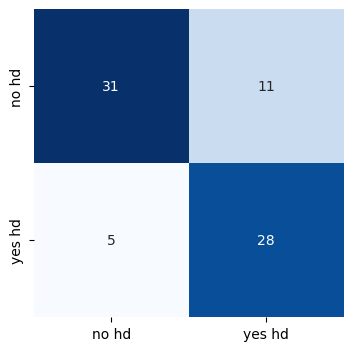

In [251]:
cm = confusion_matrix(y_test, y_pred) # confusion matrix

plt.figure(figsize=(4,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['no hd', 'yes hd'], yticklabels=['no hd', 'yes hd'])
plt.show()

# pruning - cost complexity pruning
pruning done to genearlise the fit so that it will not cause overfit and therefore large errors in the validation dataset. Done by giving penalty if more number of trees is present.

In [252]:
paths = dtc.cost_complexity_pruning_path(x_train,y_train)
dtc_alphas = paths.ccp_alphas # all possible alphas considering the largest till the root node alone
dtc_alphas = dtc_alphas[:-1] # since the last i.e. till the root node is not required

In [253]:
dtcs = []

for dtc_alpha in dtc_alphas:
    dtc_a = DecisionTreeClassifier(random_state=0, ccp_alpha=dtc_alpha) # decision tree for different alpha values
    dtc_a.fit(x_train, y_train)
    dtcs.append(dtc_a)

In [254]:
train_acc = [dtc_a.score(x_train,y_train) for dtc_a in dtcs] # accuracy score for training and testing data
test_acc = [dtc_a.score(x_test,y_test) for dtc_a in dtcs]

[]

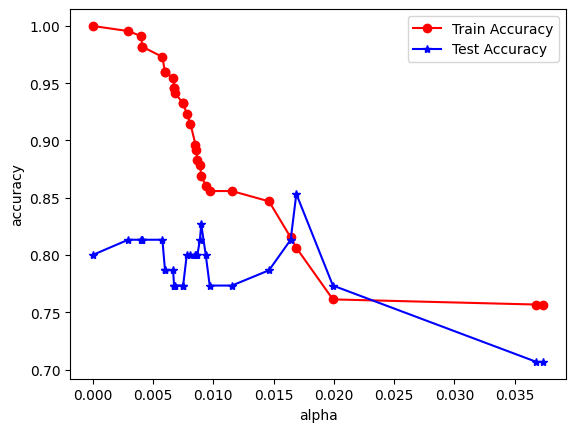

In [255]:
plt.plot(dtc_alphas, train_acc, c= "r", marker = "o", label="Train Accuracy")
plt.plot(dtc_alphas, test_acc, c= "b", marker = "*", label="Test Accuracy")
plt.legend()
plt.xlabel("alpha")
plt.ylabel("accuracy")
plt.plot()

from the above plot we can see, thaat alpha = 0.017 is a good assumption

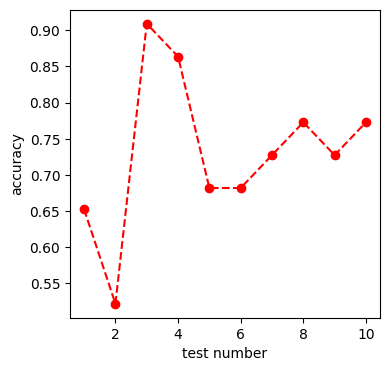

In [359]:
dtcs = DecisionTreeClassifier(random_state=42, ccp_alpha=0.017)

acc = cross_val_score(dtcs, x_train, y_train, cv = 10)

plt.figure(figsize=(4,4))
plt.plot(range(1,11), acc, c="r", marker = "o", linestyle="--")
plt.xlabel("test number")
plt.ylabel("accuracy")
plt.show()

We can see that approximate alpha value of 0.017 is causing high degree of fluctuation of accuracy for different sets of data. Therefore, much more accurate value of alpha needs to be selected.

# perform 10 fold cross validation
Since cross validation or testing if done on same test data can lead to overfit on that data, we use different sets of data of same test size. Commonly 10 sets are used. It is called 10 fold cross validation for each set of alpha value is done and the highest of each mean is taken as alpha value that gives the highest accuracy.

In [258]:
dtcs = []

for dtc_alpha in dtc_alphas:
    dtc_a = DecisionTreeClassifier(random_state=0, ccp_alpha=dtc_alpha)
    acc = cross_val_score(dtc_a, x_train, y_train, cv= 10) # compute the cross validation score for different sets of data
    dtcs.append([dtc_alpha, np.mean(acc)])

In [259]:
df_alpha = pd.DataFrame(dtcs, columns=["alpha", "mean accuracy"])

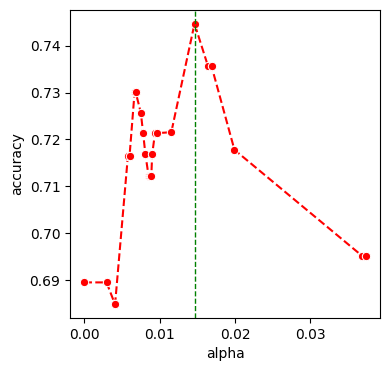

In [263]:
plt.figure(figsize=(4,4))
sns.lineplot(x="alpha", y="mean accuracy", data=df_alpha, linestyle="--", marker="o", color = "r")
plt.xlabel("alpha")
plt.ylabel("accuracy")
plt.axvline(x=0.01475, color='g', linestyle='--', linewidth=1)
plt.show()

In [266]:
# it seems like the value is between 0.016 and 0.017
alpha_crt = df_alpha[(df_alpha["alpha"] > 0.014) & (df_alpha["alpha"] < 0.015)]["alpha"] # cross validated alpha value

alpha_crt = float(alpha_crt.values[0]) # correct alpha value

# ideal classification tree 

The ideal classification tree is the pruned classfier with less number of nodes and branches and therefore will have more number of data in a particular node and will be more genearlised.

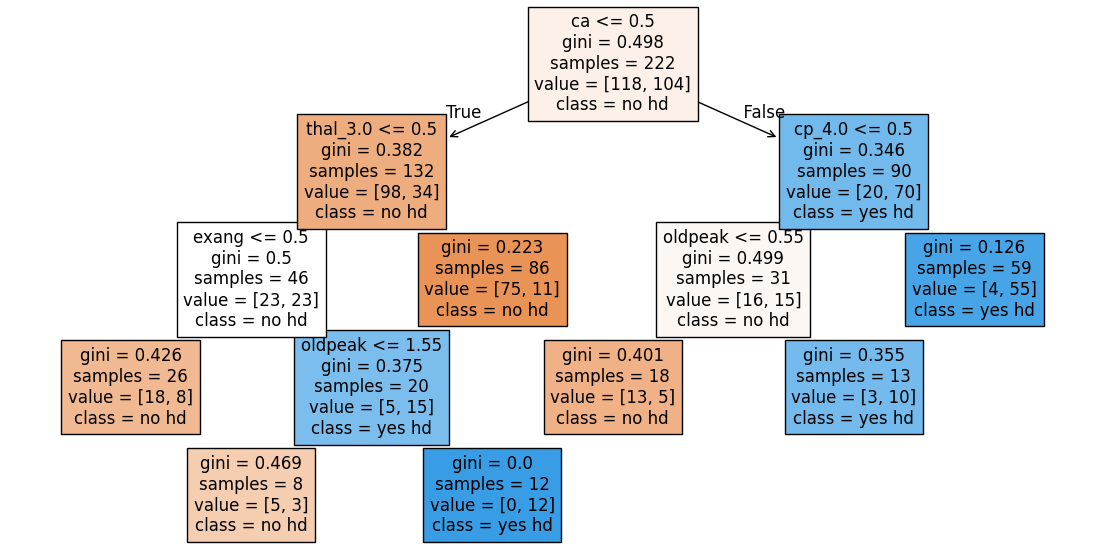

In [267]:
dtc = DecisionTreeClassifier(random_state=42, ccp_alpha= alpha_crt) # decision tree classifer

dtc = dtc.fit(x_train, y_train)

plt.figure(figsize=(14,7))
plot_tree(dtc, 
         filled = True,
         class_names=["no hd", "yes hd"],
         feature_names=x_enc.columns)
plt.show()

The darker the color, lower the gini impurity. therefore, more biased split

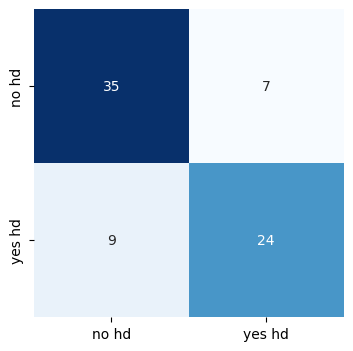

In [268]:
y_pred = dtc.predict(x_test)
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(4,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['no hd', 'yes hd'], yticklabels=['no hd', 'yes hd'])
plt.show()

Accuracy score

In [269]:
# overall accuracy - dtc.score(x_test, y_test)
acc = (cm[0,0] + cm[-1,-1])/np.sum(cm) * 100
acc

78.66666666666666

Sensitivity

In [270]:
# sensitivity
sensitivity = cm[-1,-1]/ np.sum(cm[1])
sensitivity

0.7272727272727273

Specificity

In [271]:
specificity = cm[0,0]/np.sum(cm[0]) # recall
specificity

0.8333333333333334

# Random forest classfier

For this dataset, 100 trees are formed of random variable subsets

In [304]:
rfc = RandomForestClassifier(n_estimators=100,
                             criterion="gini",
                             max_features="sqrt",
                             random_state=42,
                             bootstrap= True,
                            oob_score=True)

rfc.fit(x_train, y_train["hd"])

RandomForestClassifier(oob_score=True, random_state=42)

In [296]:
tree1 = rfc.estimators_[0] # number of trees formed

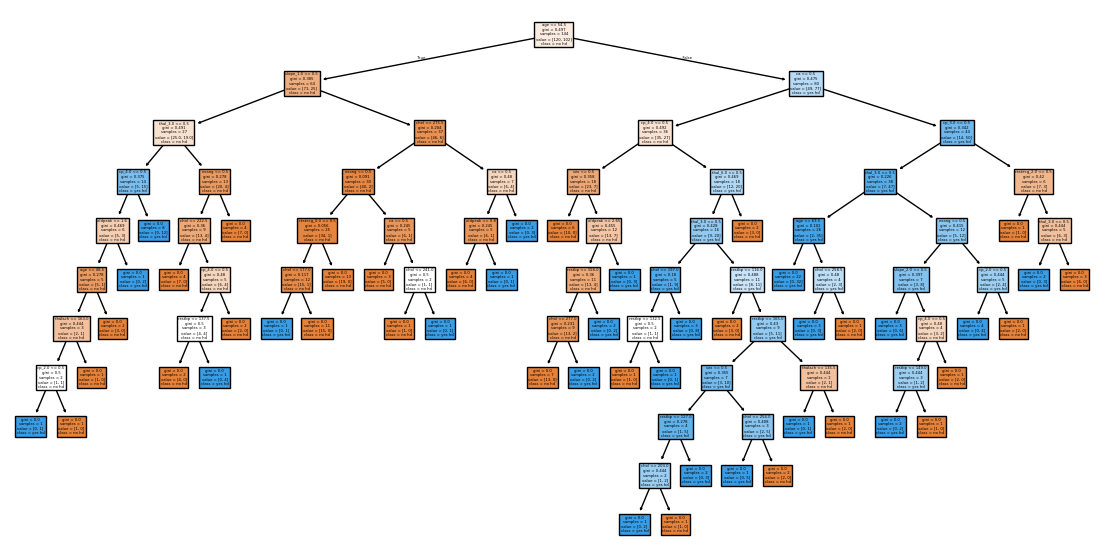

In [297]:
plt.figure(figsize=(14,7))
plot_tree(tree1, 
         filled = True,
         class_names=["no hd", "yes hd"],
         feature_names=x_enc.columns)    # an example tree
plt.show()

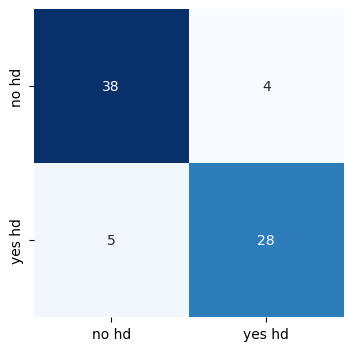

In [299]:
y_pred = rfc.predict(x_test)                # predicting the testing data
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(4,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['no hd', 'yes hd'], yticklabels=['no hd', 'yes hd'])
plt.show()

In [311]:
rfc.oob_score_ # the out of bag accuracy which is the metric in random forest

0.7972972972972973

In [319]:
test_acc = []

for n_var in range(2, x.shape[1]):                   # use diff number of features (2 to 12 in our case)
    rfc = RandomForestClassifier(n_estimators=100,
                                 criterion="gini",
                                 max_features=n_var,
                                 random_state=42,
                                 bootstrap= True,
                                oob_score=True)

    rfc.fit(x_train, y_train["hd"])

    y_pred = rfc.predict(x_test)

    test_acc.append([rfc.oob_score_, n_var])

test_acc = pd.DataFrame(test_acc, columns=["accuracy", "n variables"])

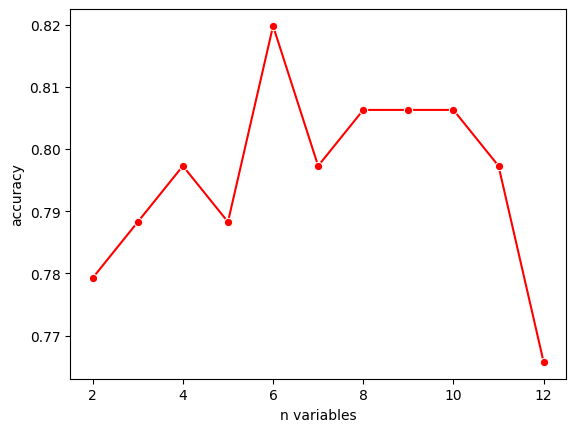

In [328]:
sns.lineplot(x = test_acc["n variables"], y = test_acc["accuracy"], data = test_acc, c = "r", marker="o")
plt.show()

We can see that the highest accuracy is achieved when the number of variables is 6.

In [337]:
# it seems like the value is between 0.016 and 0.017
n_var_crt = test_acc[test_acc["accuracy"] == test_acc["accuracy"].max()]["n variables"] # cross validated alpha value

n_var_crt = int(n_var_crt.values[0]) # taking second value since close to 0.016 already provided poor results

# ideal random forest tree

The number of variables which is giving higest out of bag accuracy is taken and therefore the ideal random forest tree is constructed. 

In [338]:
rfc = RandomForestClassifier(n_estimators=100,
                             criterion="gini",
                             max_features=n_var_crt,
                             random_state=42,
                             bootstrap= True,
                            oob_score=True)

rfc.fit(x_train, y_train["hd"])

RandomForestClassifier(max_features=6, oob_score=True, random_state=42)

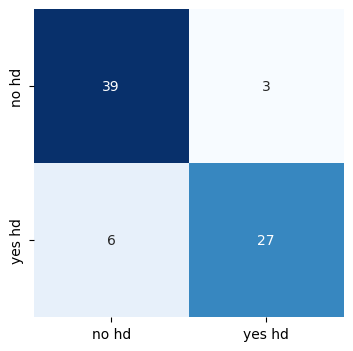

In [339]:
y_pred = rfc.predict(x_test)
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(4,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True,
            xticklabels=['no hd', 'yes hd'], yticklabels=['no hd', 'yes hd'])
plt.show()

Accuracy score

In [361]:
# overall accuracy - dtc.score(x_test, y_test)
acc = (cm[0,0] + cm[-1,-1])/np.sum(cm) * 100
acc

88.0

Sensitivity

In [362]:
# sensitivity
sensitivity = cm[-1,-1]/ np.sum(cm[1])
sensitivity

0.8181818181818182

Specificity

In [363]:
specificity = cm[0,0]/np.sum(cm[0]) # recall
specificity

0.9285714285714286

# Result:
From the above results we can see that the random forest seems to give higher accuracy (88%) than that obtrained using decision tree classifier (78.67%). This is because, random forest generalises better than decision tree algorithm due to bagging.